In [1]:
import pandas as pd, numpy as np

df = pd.read_csv('diabetes.csv')
df.head(), df.shape, df.dtypes

(   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            6      148             72             35        0  33.6   
 1            1       85             66             29        0  26.6   
 2            8      183             64              0        0  23.3   
 3            1       89             66             23       94  28.1   
 4            0      137             40             35      168  43.1   
 
    DiabetesPedigreeFunction  Age  Outcome  
 0                     0.627   50        1  
 1                     0.351   31        0  
 2                     0.672   32        1  
 3                     0.167   21        0  
 4                     2.288   33        1  ,
 (768, 9),
 Pregnancies                   int64
 Glucose                       int64
 BloodPressure                 int64
 SkinThickness                 int64
 Insulin                       int64
 BMI                         float64
 DiabetesPedigreeFunction    float64
 Age               

In [2]:
df.info()
df.describe().T

# Generic missing check
df.isna().sum()

# (Optional for the classic Pima dataset)
# Treat "0" as missing in physiological columns if present
maybe_zero_invalid = [
    'Glucose','BloodPressure','SkinThickness','Insulin','BMI'
]
for col in maybe_zero_invalid:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


<Figure size 1000x400 with 0 Axes>

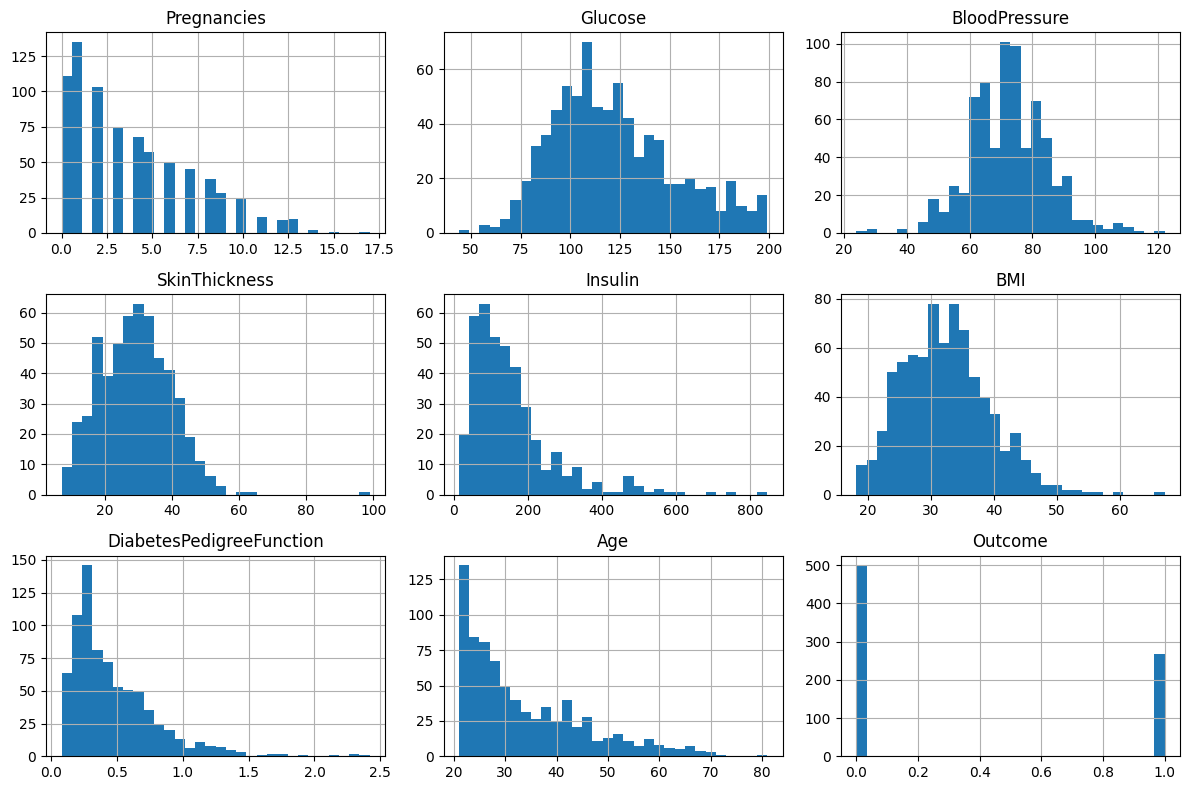

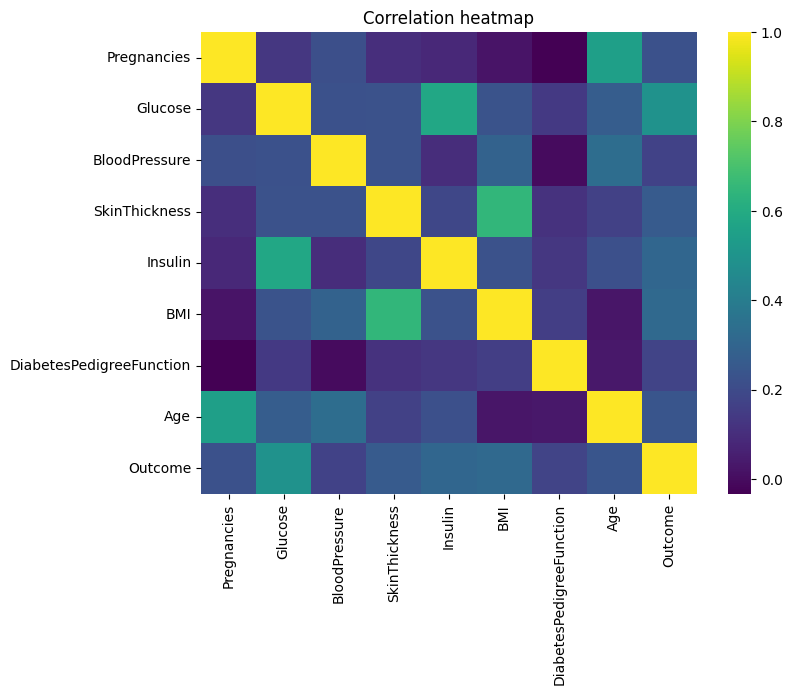

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
df.hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

if df.select_dtypes(include=[np.number]).shape[1] > 1:
    plt.figure(figsize=(8,6))
    sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='viridis')
    plt.title('Correlation heatmap')
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report)
import json

target = 'Outcome' if 'Outcome' in df.columns else df.columns[-1]
X = df.drop(columns=[target])
y = df[target]

# Two candidate models
log_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000))
])

rf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', RandomForestClassifier(n_estimators=400, random_state=42))
])

models = {'LogisticRegression': log_reg, 'RandomForest': rf}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy','precision','recall','f1','roc_auc']

cv_results = {}
for name, pipe in models.items():
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    cv_results[name] = {k: float(np.mean(v)) for k, v in res.items() if k.startswith('test')}
cv_results


{'LogisticRegression': {'test_accuracy': 0.7720906544435956,
  'test_precision': 0.7261153277092018,
  'test_recall': 0.5710691823899372,
  'test_f1': 0.6358217623317021,
  'test_roc_auc': 0.8365520614954576},
 'RandomForest': {'test_accuracy': 0.7642644936762584,
  'test_precision': 0.6857926234521978,
  'test_recall': 0.60062893081761,
  'test_f1': 0.6397979389775712,
  'test_roc_auc': 0.8279088050314467}}

In [6]:
# Train/test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


best_name = max(cv_results, key=lambda k: cv_results[k]['test_f1'])
best_model = models[best_name].fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None

test_metrics = {
    'model': best_name,
    'accuracy': float(accuracy_score(y_test, y_pred)),
    'precision': float(precision_score(y_test, y_pred, zero_division=0)),
    'recall': float(recall_score(y_test, y_pred, zero_division=0)),
    'f1': float(f1_score(y_test, y_pred, zero_division=0)),
}
if y_proba is not None:
    test_metrics['roc_auc'] = float(roc_auc_score(y_test, y_proba))

print(best_name, test_metrics)
print(classification_report(y_test, y_pred, zero_division=0))


RandomForest {'model': 'RandomForest', 'accuracy': 0.7402597402597403, 'precision': 0.6590909090909091, 'recall': 0.5370370370370371, 'f1': 0.5918367346938775, 'roc_auc': 0.8162962962962963}
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       100
           1       0.66      0.54      0.59        54

    accuracy                           0.74       154
   macro avg       0.72      0.69      0.70       154
weighted avg       0.73      0.74      0.73       154



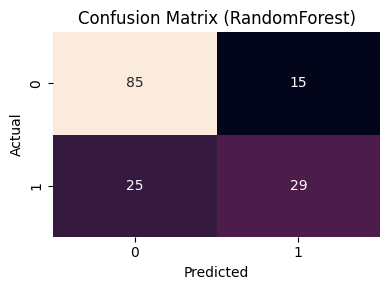

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title(f'Confusion Matrix ({best_name})')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()


In [9]:
import joblib

# Save model in pickle format
joblib.dump(best_model, 'model.pkl')

# Save feature metadata for building Streamlit inputs
feature_info = {}
for col in X.columns:
    s = df[col]
    feature_info[col] = {
        'min': float(np.nanmin(s)),
        'max': float(np.nanmax(s)),
        'median': float(np.nanmedian(s))
    }
joblib.dump(feature_info, 'feature_info.pkl')

# Save metrics (both CV and test) for the Performance section
artifacts = {
    'cv_results': cv_results,
    'test_metrics': test_metrics,
    'target': target
}
joblib.dump(artifacts, 'metrics.pkl')

# (Optional) download to your machine
from google.colab import files
for fname in ['model.pkl', 'feature_info.pkl', 'metrics.pkl', 'confusion_matrix.png']:
    files.download(fname)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>